In [ ]:
# --- Setup ---
!pip install pandas scikit-learn matplotlib sentence-transformers

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time

# Try OpenAI if available
try:
    from openai import OpenAI
    import os
    USE_OPENAI = True
except ImportError:
    USE_OPENAI = False


# Initialize OpenAI client if available
if USE_OPENAI and os.getenv("OPENAI_API_KEY"):
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
else:
    client = None
    USE_OPENAI = False


In [ ]:
data = [
    {"name": "Boho Dress",
     "desc": "Flowy, earthy tones for free-spirited festival vibes.",
     "vibes": ["boho", "relaxed", "nature"]},

    {"name": "Streetwear Hoodie",
     "desc": "Oversized, graphic design, bold colors for an energetic city look.",
     "vibes": ["urban", "energetic", "casual"]},

    {"name": "Classic Blazer",
     "desc": "Tailored fit with minimal design, perfect for formal or semi-formal office days.",
     "vibes": ["chic", "professional", "clean"]},

    {"name": "Cozy Knit Sweater",
     "desc": "Soft wool fabric for warmth and comfort during winter evenings.",
     "vibes": ["cozy", "soft", "homey"]},

    {"name": "Denim Jacket",
     "desc": "Rugged denim layer for casual yet timeless street vibes.",
     "vibes": ["casual", "classic", "street"]},

    {"name": "Athleisure Set",
     "desc": "Breathable and flexible workout outfit, perfect for gym or cafe runs.",
     "vibes": ["sporty", "active", "urban"]},

    {"name": "Silk Evening Gown",
     "desc": "Elegant silk gown with a sleek silhouette and subtle shimmer.",
     "vibes": ["luxury", "formal", "chic"]},

    {"name": "Floral Midi Skirt",
     "desc": "Lightweight skirt with floral prints ideal for spring days.",
     "vibes": ["feminine", "cheerful", "boho"]},

    {"name": "Leather Boots",
     "desc": "Tough, high-ankle boots for confident and bold personalities.",
     "vibes": ["edgy", "bold", "urban"]},

    {"name": "Puffer Jacket",
     "desc": "Functional and warm jacket with a modern winter aesthetic.",
     "vibes": ["cozy", "urban", "functional"]}
]

df = pd.DataFrame(data)
df


,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones for free-spirited festival...","[boho, relaxed, nature]"
1,Streetwear Hoodie,"Oversized, graphic design, bold colors for an ...","[urban, energetic, casual]"
2,Classic Blazer,"Tailored fit with minimal design, perfect for ...","[chic, professional, clean]"
3,Cozy Knit Sweater,Soft wool fabric for warmth and comfort during...,"[cozy, soft, homey]"
4,Denim Jacket,Rugged denim layer for casual yet timeless str...,"[casual, classic, street]"
5,Athleisure Set,"Breathable and flexible workout outfit, perfec...","[sporty, active, urban]"
6,Silk Evening Gown,Elegant silk gown with a sleek silhouette and ...,"[luxury, formal, chic]"
7,Floral Midi Skirt,Lightweight skirt with floral prints ideal for...,"[feminine, cheerful, boho]"
8,Leather Boots,"Tough, high-ankle boots for confident and bold...","[edgy, bold, urban]"
9,Puffer Jacket,Functional and warm jacket with a modern winte...,"[cozy, urban, functional]"


In [ ]:
from sentence_transformers import SentenceTransformer

# Try OpenAI embeddings, else fallback to local model or mock
def get_embedding(text):
    global USE_OPENAI
    if USE_OPENAI and client:
        try:
            response = client.embeddings.create(input=text, model="text-embedding-ada-002")
            return response.data[0].embedding
        except Exception as e:
            print("⚠️ OpenAI API unavailable — switching to local embeddings.")
            USE_OPENAI = False

    # Local fallback model (free)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    return model.encode(text)

# Generate embeddings
start = time.time()
df["embedding"] = df["desc"].apply(get_embedding)
end = time.time()
print(f"✅ Embeddings generated in {end - start:.2f}s using {'OpenAI' if USE_OPENAI else 'local model'}")


✅ Embeddings generated in 14.14s using local model


In [ ]:
def vibe_matcher(query, df, top_k=3):
    query_emb = get_embedding(query)
    sim_scores = cosine_similarity([query_emb], list(df["embedding"]))[0]
    df["score"] = sim_scores

    top_matches = df.sort_values("score", ascending=False).head(top_k)[["name", "desc", "score"]]

    if top_matches["score"].max() < 0.5:
        print("⚠️ No strong vibe match found — try a clearer vibe prompt.")
    return top_matches


In [ ]:
queries = [
    "energetic urban chic",
    "soft and cozy winter outfit",
    "luxurious evening style"
]

results, latencies = [], []

for q in queries:
    start_time = time.time()
    res = vibe_matcher(q, df)
    latency = time.time() - start_time
    latencies.append(latency)
    print(f"\nQuery: '{q}'")
    print(res)
    results.append(res)
    print(f"⏱️ Latency: {latency:.2f}s")


⚠️ No strong vibe match found — try a clearer vibe prompt.

Query: 'energetic urban chic'
                name                                               desc  \
1  Streetwear Hoodie  Oversized, graphic design, bold colors for an ...   
0         Boho Dress  Flowy, earthy tones for free-spirited festival...   
5     Athleisure Set  Breathable and flexible workout outfit, perfec...   

      score  
1  0.498744  
0  0.332435  
5  0.330257  
⏱️ Latency: 1.84s

Query: 'soft and cozy winter outfit'
                name                                               desc  \
9      Puffer Jacket  Functional and warm jacket with a modern winte...   
3  Cozy Knit Sweater  Soft wool fabric for warmth and comfort during...   
7  Floral Midi Skirt  Lightweight skirt with floral prints ideal for...   

      score  
9  0.710870  
3  0.660268  
7  0.524229  
⏱️ Latency: 1.57s

Query: 'luxurious evening style'
                name                                               desc  \
1  Streetwear


Good matches: 1/9


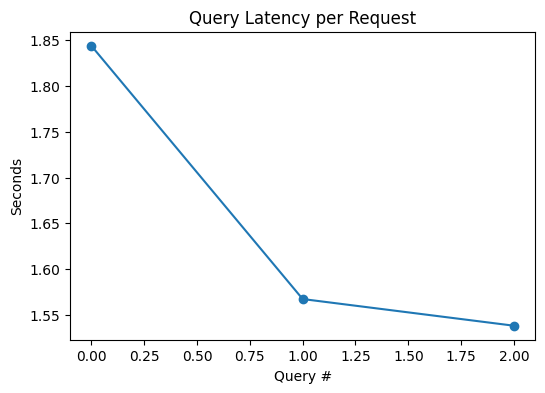

In [ ]:
good_matches = sum([sum(r["score"] > 0.7) for r in results])
total = sum([len(r) for r in results])
print(f"\nGood matches: {good_matches}/{total}")

plt.figure(figsize=(6,4))
plt.plot(latencies, marker='o')
plt.title("Query Latency per Request")
plt.xlabel("Query #")
plt.ylabel("Seconds")
plt.show()
